In [1]:
import sys
import subprocess

def install_if_missing(package):
    """Install a Python package if missing."""
    try:
        __import__(package)
    except ImportError:
        print(f"Installing missing package: {package}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])


install_if_missing("kagglehub")
install_if_missing("pandas")
install_if_missing("matplotlib")
install_if_missing("seaborn")
install_if_missing("tqdm")
install_if_missing("numpy")

import kagglehub
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

c:\Users\FED\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. DOWNLOAD DATASET FROM KAGGLEHUB

In [2]:
print("\nDownloading SeaDronesSee dataset via KaggleHub...")
dataset_path = kagglehub.dataset_download("ubiratanfilho/sds-dataset")
dataset_path = Path(dataset_path)

print(f"Dataset downloaded to: {dataset_path}")

# According to KaggleHub structure
raw_root = dataset_path / "compressed"

ann_train = raw_root / "annotations" / "instances_train.json"
ann_val   = raw_root / "annotations" / "instances_val.json"

img_train = raw_root / "images" / "train"
img_val   = raw_root / "images" / "val"

print("\nLocated annotations:")
print(f"  Train: {ann_train}")
print(f"  Val  : {ann_val}")

print("\nLocated images:")
print(f"  Train imgs: {img_train}")
print(f"  Val imgs  : {img_val}")


Dataset downloaded to: C:\Users\FED\.cache\kagglehub\datasets\ubiratanfilho\sds-dataset\versions\1

Located annotations:
  Train: C:\Users\FED\.cache\kagglehub\datasets\ubiratanfilho\sds-dataset\versions\1\compressed\annotations\instances_train.json
  Val  : C:\Users\FED\.cache\kagglehub\datasets\ubiratanfilho\sds-dataset\versions\1\compressed\annotations\instances_val.json

Located images:
  Train imgs: C:\Users\FED\.cache\kagglehub\datasets\ubiratanfilho\sds-dataset\versions\1\compressed\images\train
  Val imgs  : C:\Users\FED\.cache\kagglehub\datasets\ubiratanfilho\sds-dataset\versions\1\compressed\images\val


## 2. LOAD COCO ANNOTATIONS

In [3]:
def load_coco(path_json):
    with open(path_json, "r") as f:
        d = json.load(f)
    return d

train_coco = load_coco(ann_train)
val_coco   = load_coco(ann_val)

print("\nLoaded COCO annotations.")
print(f"  Train images: {len(train_coco['images'])}")
print(f"  Train ann   : {len(train_coco['annotations'])}")
print(f"  Val images  : {len(val_coco['images'])}")
print(f"  Val ann     : {len(val_coco['annotations'])}")


Loaded COCO annotations.
  Train images: 8930
  Train ann   : 57760
  Val images  : 1547
  Val ann     : 9630


## 3. MERGE TRAIN + VAL INTO A SINGLE STRUCTURE

In [4]:
def coco_to_df(coco_dict, split_name):
    """Convert COCO dict into a flat DataFrame."""
    images = {img["id"]: img["file_name"] for img in coco_dict["images"]}

    rows = []
    for ann in coco_dict["annotations"]:
        rows.append({
            "image_id": ann["image_id"],
            "filename": images.get(ann["image_id"], None),
            "category_id": ann["category_id"],
            "bbox": ann["bbox"],
            "area": ann["area"],
            "split": split_name
        })

    return pd.DataFrame(rows)

df_train = coco_to_df(train_coco, "train")
df_val   = coco_to_df(val_coco, "val")
df_all   = pd.concat([df_train, df_val], ignore_index=True)

print("\nMerged annotations into single DataFrame:")
print(df_all.head())
print(df_all.shape)


Merged annotations into single DataFrame:
   image_id  filename  category_id                  bbox  area  split
0      3388  3388.jpg            2  [3619, 1409, 75, 38]  2850  train
1      3389  3389.jpg            2  [3524, 1408, 73, 37]  2701  train
2      3390  3390.jpg            2  [3399, 1406, 71, 36]  2556  train
3      3391  3391.jpg            2  [3267, 1152, 70, 35]  2450  train
4      3392  3392.jpg            2   [3053, 784, 65, 33]  2145  train
(67390, 6)


## 4. EXTRACT CATEGORY NAMES

In [5]:
categories = {c["id"]: c["name"] for c in train_coco["categories"]}

# Remove category 0 if it exists ("ignored")
if 0 in categories:
    print("Removing category_id == 0 from dataset.")
    df_all = df_all[df_all["category_id"] != 0]

print("\nCategories present:")
for cid, name in categories.items():
    if cid != 0:
        print(f"  {cid}: {name}")

# Add readable class names
df_all["class_name"] = df_all["category_id"].map(categories)

Removing category_id == 0 from dataset.

Categories present:
  1: swimmer
  2: boat
  3: jetski
  4: life_saving_appliances
  5: buoy


## 5. BASIC STATS

In [6]:
print("\nBasic statistics:")
print(f"Total annotations: {len(df_all)}")
print(f"Unique images: {df_all['image_id'].nunique()}")

class_counts = df_all["class_name"].value_counts()
print("\nClass distribution:")
print(class_counts)

# transform the distribution in percentages
class_percentages = (class_counts / class_counts.sum()) * 100
print("\nClass distribution (percentages):")
print(class_percentages)


Basic statistics:
Total annotations: 67390
Unique images: 10477

Class distribution:
class_name
swimmer                   43302
boat                      15236
buoy                       4949
jetski                     2650
life_saving_appliances     1253
Name: count, dtype: int64

Class distribution (percentages):
class_name
swimmer                   64.255824
boat                      22.608696
buoy                       7.343820
jetski                     3.932334
life_saving_appliances     1.859326
Name: count, dtype: float64


## 6. SIMPLE PLOTS

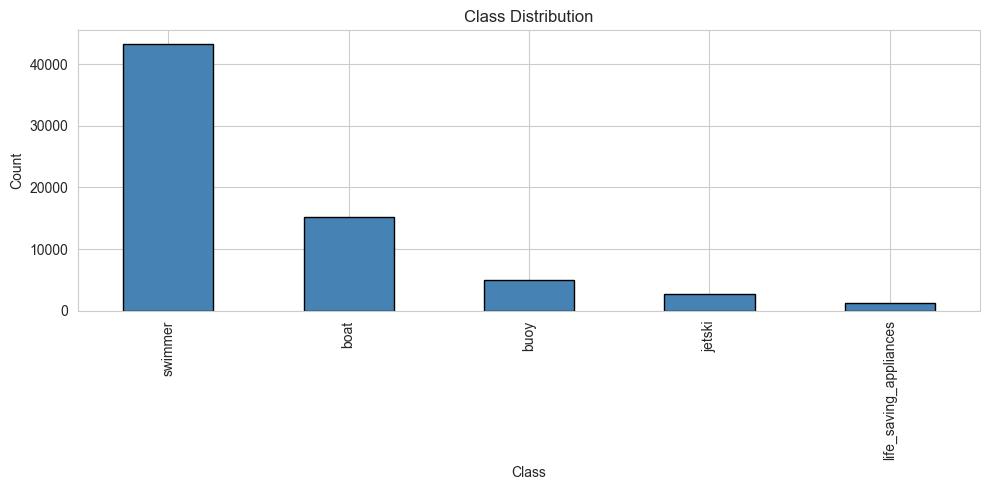

<BarContainer object of 16 artists>

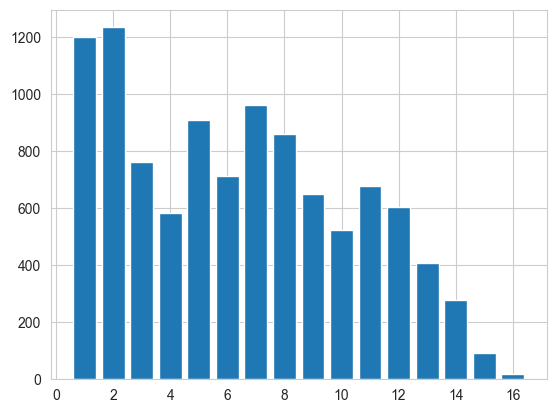

In [14]:
sns.set_style("whitegrid")

# ---- Plot 1: class distribution (bar chart)
plt.figure(figsize=(10, 5))
class_counts.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---- Plot 2: objects per image distribution
objs_per_img = df_all.groupby("image_id").size()
objs_per_img_counts = objs_per_img.value_counts().sort_index()
plt.bar(objs_per_img_counts.index, objs_per_img_counts.values)


In [13]:
dominant_class_counts = df_all.groupby("image_id")["category_id"].agg(lambda x: x.value_counts().idxmax()).value_counts().sort_index()
print("Dominant class per image (count of images where each class is dominant):")
print(dominant_class_counts)

Dominant class per image (count of images where each class is dominant):
category_id
1    6847
2    3084
3     203
4      21
5     322
Name: count, dtype: int64


## PREPARING MULTILABEL STRATIFIED TRAIN/VAL/TEST SPLIT

In [14]:
install_if_missing("iterative-stratification")
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

Installing missing package: iterative-stratification


## 1. UNIQUE IMAGES + CLASS MAPPING

In [15]:
unique_images = df_all["image_id"].unique()
unique_images.sort()

class_ids = sorted(df_all["category_id"].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_ids)}

print("\nClass → Index mapping:")
print(class_to_idx)


Class → Index mapping:
{np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4}


## 2. BUILD MULTI-HOT MATRIX (y)

In [16]:
X = unique_images.reshape(-1, 1)  
y = np.zeros((len(unique_images), len(class_ids)), dtype=int)

for i, img_id in enumerate(unique_images):
    img_classes = df_all[df_all["image_id"] == img_id]["category_id"].unique()
    for cls in img_classes:
        y[i, class_to_idx[cls]] = 1

print("\nX shape:", X.shape)
print("y shape:", y.shape)


X shape: (10477, 1)
y shape: (10477, 5)


## 3. FIRST SPLIT → TRAIN (75%) + TEMP (25%)

In [17]:
msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.25,
    random_state=42
)

train_idx, temp_idx = next(msss.split(X, y))

# Extract subsets
X_train = X[train_idx]
y_train = y[train_idx]

X_temp = X[temp_idx]
y_temp = y[temp_idx]

print("\nSplit 1 completed.")
print("Train images:", len(X_train))
print("Temp images :", len(X_temp))


Split 1 completed.
Train images: 7867
Temp images : 2610


## 4. SECOND SPLIT → VAL (15%) + TEST (10%) - We split TEMP into: 40% test, 60% val because TEMP = 25% of total → 25% * 0.4 = 10%, 25% * 0.6 = 15%

In [18]:
msss2 = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.40,   # test = 10% of original
    random_state=42
)

val_idx, test_idx = next(msss2.split(X_temp, y_temp))

X_val = X_temp[val_idx]
y_val = y_temp[val_idx]

X_test = X_temp[test_idx]
y_test = y_temp[test_idx]

print("\nSplit 2 completed.")
print("Validation images:", len(X_val))
print("Test images      :", len(X_test))


Split 2 completed.
Validation images: 1563
Test images      : 1047


## 5. FUNCTION: CLASS DISTRIBUTION CHECK

In [19]:
def compute_distribution(X_subset, df_all):
    img_ids = X_subset.flatten()
    subset = df_all[df_all["image_id"].isin(img_ids)]

    abs_counts = subset["class_name"].value_counts().sort_index()
    pct_counts = (abs_counts / abs_counts.sum()) * 100

    return abs_counts, pct_counts

## 6. PRINT DISTRIBUTIONS FOR ALL SPLITS

In [20]:
splits = {
    "TRAIN": X_train,
    "VAL":   X_val,
    "TEST":  X_test
}

for name, X_part in splits.items():
    abs_c, pct_c = compute_distribution(X_part, df_all)

    print(f"\n=== {name} SPLIT — ABSOLUTE DISTRIBUTION ===")
    print(abs_c)

    print(f"\n=== {name} SPLIT — PERCENTAGE DISTRIBUTION ===")
    print(pct_c.round(3))

print("\nMultilabel stratified splitting completed successfully.")


=== TRAIN SPLIT — ABSOLUTE DISTRIBUTION ===
class_name
boat                      11389
buoy                       3723
jetski                     1988
life_saving_appliances      932
swimmer                   32597
Name: count, dtype: int64

=== TRAIN SPLIT — PERCENTAGE DISTRIBUTION ===
class_name
boat                      22.495
buoy                       7.353
jetski                     3.927
life_saving_appliances     1.841
swimmer                   64.384
Name: count, dtype: float64

=== VAL SPLIT — ABSOLUTE DISTRIBUTION ===
class_name
boat                      2347
buoy                       743
jetski                     397
life_saving_appliances     188
swimmer                   6450
Name: count, dtype: int64

=== VAL SPLIT — PERCENTAGE DISTRIBUTION ===
class_name
boat                      23.180
buoy                       7.338
jetski                     3.921
life_saving_appliances     1.857
swimmer                   63.704
Name: count, dtype: float64

=== TEST SPLIT — ABSOL

## YOLOv8 EXPORT (IMAGES + LABELS)

In [21]:
import shutil

# Root folder for final YOLO dataset
yolo_root = Path("yolo_dataset")
images_out = yolo_root / "images"
labels_out = yolo_root / "labels"

# Create directory structure
for split in ["train", "val", "test"]:
    (images_out / split).mkdir(parents=True, exist_ok=True)
    (labels_out / split).mkdir(parents=True, exist_ok=True)

print("\nCreated YOLO directory structure.")


Created YOLO directory structure.


## Build a dictionary: image_id → metadata (width, height, file)

In [22]:
def build_image_lookup(coco_train, coco_val):
    lookup = {}
    for record in coco_train["images"] + coco_val["images"]:
        lookup[record["id"]] = {
            "file_name": record["file_name"],
            "width": record["width"],
            "height": record["height"],
        }
    return lookup

image_lookup = build_image_lookup(train_coco, val_coco)

## Collect image paths from KaggleHub folders

In [23]:
def find_image_path(filename):
    p1 = img_train / filename
    p2 = img_val / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    return None

## COCO → YOLO conversion function

In [24]:
def coco_bbox_to_yolo(bbox, img_w, img_h):
    x, y, w, h = bbox
    cx = (x + w / 2) / img_w
    cy = (y + h / 2) / img_h
    w_norm = w / img_w
    h_norm = h / img_h
    return cx, cy, w_norm, h_norm

## Create a lookup: split_name → list of image_ids

In [25]:
split_map = {
    "train": X_train.flatten(),
    "val":   X_val.flatten(),
    "test":  X_test.flatten(),
}

# Class-id remapping for YOLO: 0..(num_classes-1)
sorted_classes = sorted(class_to_idx.keys())          # e.g. [1,2,3,4,5]
yolo_id_map = {cls_id: i for i, cls_id in enumerate(sorted_classes)}

print("\nYOLO class mapping (COCO → YOLO):")
print(yolo_id_map)


YOLO class mapping (COCO → YOLO):
{np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4}


## EXPORT LOOP

In [26]:
for split_name, image_ids in split_map.items():
    print(f"\nExporting {split_name} set ({len(image_ids)} images)...")

    for img_id in tqdm(image_ids):

        # -------------------------------
        # Metadata lookup
        # -------------------------------
        if img_id not in image_lookup:
            continue
        meta = image_lookup[img_id]

        filename = meta["file_name"]
        img_w = meta["width"]
        img_h = meta["height"]

        # -------------------------------
        # Find image path
        # -------------------------------
        src_img_path = find_image_path(filename)
        if src_img_path is None:
            continue  # skip missing images

        # Destination image path
        dst_img_path = images_out / split_name / filename

        # Copy image
        shutil.copy(src_img_path, dst_img_path)

        # -------------------------------
        # Build YOLO annotation file
        # -------------------------------
        label_path = labels_out / split_name / (filename.replace(".jpg", ".txt"))

        # Extract all annotations for this image
        anns = df_all[df_all["image_id"] == img_id]

        with open(label_path, "w") as f:
            for _, row in anns.iterrows():
                cls = row["category_id"]
                if cls not in yolo_id_map:
                    continue

                yolo_cls = yolo_id_map[cls]
                x_yolo, y_yolo, w_yolo, h_yolo = coco_bbox_to_yolo(
                    row["bbox"], img_w, img_h
                )

                # Write YOLO annotation line
                f.write(f"{yolo_cls} {x_yolo:.6f} {y_yolo:.6f} {w_yolo:.6f} {h_yolo:.6f}\n")

print("\nExport completed successfully.")


Exporting train set (7867 images)...


100%|██████████| 7867/7867 [00:35<00:00, 218.71it/s]



Exporting val set (1563 images)...


100%|██████████| 1563/1563 [00:08<00:00, 173.85it/s]



Exporting test set (1047 images)...


100%|██████████| 1047/1047 [00:05<00:00, 184.69it/s]


Export completed successfully.


## WRITE dataset.yaml

In [28]:
dataset_yaml = yolo_root / "dataset.yaml"

names_dict = {i: categories[cid] for cid, i in yolo_id_map.items()}

with open(dataset_yaml, "w") as f:
    f.write(f"path: {yolo_root.resolve()}\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("test: images/test\n\n")
    f.write("names:\n")
    for i, name in names_dict.items():
        f.write(f"  {i}: {name}\n")

print(f"\nWrote YOLO dataset.yaml → {dataset_yaml}")
print("\nREADY FOR TRAINING.")


Wrote YOLO dataset.yaml → yolo_dataset\dataset.yaml

READY FOR TRAINING.
